
# Addressing text classification as a Graph classification problem using GNNs

This notebook has the objective of guiding developers through the cast of text classification, the most common NLP task, as a graph classification problem. <br>
<br>
In particular, by considering sentences as a series of words, each with an associated embedding, connected with eachother through means of sintactic relationship, we can model the formers as 
graphs and proceed to classificate them. 
<br>
<br>
In this work we decided to consider pre-trained BERT embeddings as the embeddings of the words, as they manage to keep the semantic information 
as well as positional information, which is really important considering the fact that these embeddings will be aggregated through means of Graph Convolution or Graph Attention layers according to the syntax of the sentence itself, which is not a sequential structure. 
<br>
<br>
Since the objective is to understand how the problem could be tackled, 
we decided to keep training recipes as simple as possible, as the focus is shifted towards the representation of the data and how it is handled by GNNs. 


## About the Dataset

We decided to perform text classification on a dataset of tweets related to Covid-19, where the target feature is a sentiment expressed by the tweet in relation to the pandemic, we list below the domain of the target feature as well as some associated examples: <br>
- Extremely Positive sentiment: "We thank you for your patience during this time" <br>
- Positive sentiment: "I've been following social distancing rules and staying home to prevent the spread of you.  However, now I've spent an alarming amount of money shopping online.  Where can I submit my expenses to for reimbursement? Let me know."
- Neutral sentiment: "The COVID-19 coronavirus pandemic is impacting consumer shopping behavior, purchase decisions and retail sales, according to a First Insight study."
- Negative sentiment: "what is being done to ensure food and other essential products are being re-stocked at supermarkets and panic buying actively discouraged? It cannot be left to checkout staff to police the actions of the selfish and profiteer"
- Extremely negative sentiment: "Not because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage..."
<br>

The decision to consider this dataset was took for three practical reasons:
- It consists in a huge amount of entries (more than 41k tweets only in the training set)
considering that everything should run on Google Colab
- Only a few words can be used to discriminate between classes, appropriate enough since the objective is to check wether injecting structural information can be an effective strategy to automatically learn embeddings that give more value to the most important terms
- Since the dataset is on kaggle, we will have the possibility to compare our approach other relevant approaches often used in literature, such as BERT fine-tuning

<br>

The kaggle web page related to the dataset can be found here: <br>
https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

## Required external libraries

The problem of casting text classification as graph classification is handled with:
- Stanza, a Natural Language Analysis tool, essentially the evolution of NLTK,
this will be needed in order to tokenize sentences and perform the dependency parsing, as will be shown below, we are actually working on tree structure with a small variant: only a single node will have a link to himself and it is node "0", the one that should represent the whole sentence wich has an in-link with the main verb. For more informations about Stanza it is possible to visit the official website: <br> https://stanfordnlp.github.io/stanza/
- Graphviz, an open-source tool to visualize graphs, it will be useful to understand what outputs are provided by the dependency parser and what we are actually feeding to our GNNs. The complete documentation can be found in the official website:<br> https://graphviz.org/
- Transformers, wich is the library provided by Hugging Face that provides the APIs needed to easily download and train state-of-the-art pretrained transformer-based model, it is essential if we want to use BERT embeddings.
Again, we remind to the official website for the complete documentation:<br>
https://huggingface.co/docs/transformers/index
- Pytorch Geometric, it is the library to handle Graph Neural Networks, it will be used to build our GNNs as well as constructing, saving and loading the final, processed dataset of graphs. The documentation can be found here:<br>
https://pytorch-geometric.readthedocs.io/en/latest/

In [1]:
# download of the libraries
!pip install stanza
!pip install graphviz
!pip install transformers
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.5/802.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=1b875f01f25575f60c95fbd6f1759c214c70638954502c76d5bd74332f2bdac7
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 10

In [2]:
# import of the libraries
import numpy as np
import os
import os.path as osp
import shutil

import stanza

from graphviz import Source

from transformers import AutoTokenizer, BertModel
import torch
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, InMemoryDataset
from torch_geometric.utils import scatter, to_networkx, to_undirected, degree
from torch_geometric.nn import GCNConv, GATv2Conv, global_mean_pool
import torch.nn.functional as F
from torch.nn import Linear, Dropout

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm

import re

%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# GPU acceleration is a key factor in speeding up the computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# initialization of the stanza pipeline to get dependency graphs
stanza.download("en")
nlp = stanza.Pipeline('en', use_gpu = True)

INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| constituency | wsj       |
| depparse     | combined  |
| sentiment    | sstplus   |
| ner          | ontonotes |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: constituency
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


# Dependency scheme
The sentence below is parsed so that a dependency graph is built in the
following way:
- Each word is associated to an index in [1, num_words]
- Each word has an outlink (head index) to the part of speech to wich it refers
- The word with head index equal to 0 is the govenor word, most of the times it is the main verb, but in this example it is the word "example"
- The other parts of speech have head index > 1 and are connected to eachother according to the Universal Dependencies scheme.
- Since no token in the sentence has index 0, it will have a "special" embedding in our graph representation
<br>

More informations can be found here: <br>
https://universaldependencies.org/introduction.html

In [5]:
%%time
def print_example(example_sentence):
  nlp_example_sentence = nlp(example_sentence)
  to_print = []
  for sentence in nlp_example_sentence.sentences:
    cur_str = ""
    for word in sentence.words:
      if len(word.text) < 2:
        # we add an additional tabulation if the word is shorter than 2 characters
        cur_str = f"id: {word.id}\tword: {word.text}\t\t\thead id: {word.head}" 
      elif len(word.text) >= 10:
        # we remove a tabulation
        cur_str = f"id: {word.id}\tword: {word.text}\thead id: {word.head}"
      else:
        cur_str = f"id: {word.id}\tword: {word.text}\t\thead id: {word.head}"
      to_print.append(cur_str)
  for elem in to_print:
    print(elem)

print_example("This is an example needed to understand how the dependency parser, from the Stanza library, works.")

id: 1	word: This		head id: 4
id: 2	word: is		head id: 4
id: 3	word: an		head id: 4
id: 4	word: example		head id: 0
id: 5	word: needed		head id: 4
id: 6	word: to		head id: 7
id: 7	word: understand	head id: 5
id: 8	word: how		head id: 18
id: 9	word: the		head id: 11
id: 10	word: dependency	head id: 11
id: 11	word: parser		head id: 18
id: 12	word: ,			head id: 11
id: 13	word: from		head id: 16
id: 14	word: the		head id: 16
id: 15	word: Stanza		head id: 16
id: 16	word: library		head id: 11
id: 17	word: ,			head id: 11
id: 18	word: works		head id: 7
id: 19	word: .			head id: 4
CPU times: user 952 ms, sys: 319 ms, total: 1.27 s
Wall time: 4.67 s


## Note well
Since the output of the Stanza pipeline to create dependency graphs can consider more sentences at once, we have to create a dictionary where:
- the keys are strings in the format "{idx} tokens" or "{idx} dependency", where idx is the index of the sentece ("0 tokens" is the key for the list of tokens of the first sentence, "1 dependency" is the key for the list of dependencies, namely the edges of the dependency graph, for the second sentence)
- the values can be either lists of tokens or list of dependencies in the COO format, a common notation for sparse matrices:<br>
https://scipy-lectures.org/advanced/scipy_sparse/coo_matrix.html



In [6]:
# function for the construction of the dictionary containing tokens and
# dependencies
def get_tokens_and_dependencies(to_tokenize):
  nlp_dep = nlp(to_tokenize)
  to_return = {}
  for idx, sentence in enumerate(nlp_dep.sentences):
    token_list = np.array([])
    heads_arr = np.array([0], dtype=np.int32)
    for word in sentence.words:
      token_list = np.append(token_list, word.text)
      heads_arr = np.append(heads_arr, word.head) 
    starting_nodes = np.arange(0, heads_arr.shape[0])
    dependency_arr = np.vstack((starting_nodes, heads_arr))
    to_return.update({f"{idx} tokens": token_list, f"{idx} dependency":dependency_arr})
  return to_return

In [ ]:
# output example
returned_dict = get_tokens_and_dependencies("My babe don't stand no cheating, of course she will believe me. Oh yes, she don't stand no cheating")
print(returned_dict["0 tokens"])
print(returned_dict["0 dependency"])
print(returned_dict["1 tokens"])
print(returned_dict["1 dependency"])

['My' 'babe' 'do' "n't" 'stand' 'no' 'cheating' ',' 'of' 'course' 'she'
 'will' 'believe' 'me' '.']
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  2  5  5  5  0  7  5  5 13  9 13 13  5 13  5]]
['Oh' 'yes' ',' 'she' 'do' "n't" 'stand' 'no' 'cheating']
[[0 1 2 3 4 5 6 7 8 9]
 [0 7 7 2 7 7 7 0 9 7]]


# Import of the BERT model

Since Stanza already produces tokens, we need the BERT tokenizer in order to get the corresponding ids, wich will be fed to the BERT model to obtain the embeddings

In [7]:
# initialization of the tokenizer and the bert model
# to compute the embeddings for each token
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# example of usage
%%time
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt").to(device)
outputs = bert_model(**inputs)
last_hidden_states = outputs.last_hidden_state

CPU times: user 14.7 ms, sys: 2.54 ms, total: 17.2 ms
Wall time: 28.2 ms


In [ ]:
print(inputs)
print(outputs.last_hidden_state.shape)
print(outputs.last_hidden_state[0, 1, :].shape)
print(outputs.pooler_output.shape)

{'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]],
       device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
torch.Size([1, 8, 768])
torch.Size([768])
torch.Size([1, 768])


In [ ]:
# we are actually converting stanza tokens to bert ids
maybe = tokenizer.convert_tokens_to_ids(returned_dict["0 tokens"])
print(torch.tensor(maybe))

tensor([  100, 11561,  2079,   100,  3233,  2053, 16789,  1010,  1997,  2607,
         2016,  2097,  2903,  2033,  1012])


In [9]:
# given a list of tokens, this function returns a dictionary where
# the corresponding input_ids, token_type_ids and attention mask are stored
def get_bert_input_from_tokens(token_list):
  ids = np.array(tokenizer.convert_tokens_to_ids(token_list))
  input_ids = torch.tensor(ids.reshape(1, ids.shape[0]), dtype = torch.int32)
  len_tens = input_ids.shape[1]
  token_type_ids = torch.tensor(np.zeros(len_tens, dtype = int).reshape(1, len_tens), dtype = torch.int32)
  attn_mask = torch.tensor(np.ones(len_tens, dtype = int).reshape(1, len_tens), dtype = torch.int32)
  to_return = {"input_ids":input_ids.to(device), "token_type_ids":token_type_ids.to(device), "attention_mask":attn_mask.to(device)}
  return to_return

In [ ]:
sentence = returned_dict["0 tokens"]
print(len(sentence))
to_pass_to_bert = get_bert_input_from_tokens(sentence)
print(to_pass_to_bert)
# the ** notation is used in order to pass the elements of the
# dictionary as a variable number of arguments to the BERT model
obt_outputs = bert_model(**to_pass_to_bert)

print(obt_outputs.last_hidden_state.shape)

15
{'input_ids': tensor([[  100, 11561,  2079,   100,  3233,  2053, 16789,  1010,  1997,  2607,
          2016,  2097,  2903,  2033,  1012]], device='cuda:0',
       dtype=torch.int32), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0',
       dtype=torch.int32), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0',
       dtype=torch.int32)}
torch.Size([1, 15, 768])


# Data objects

`torch_geometric` has its special way to define learnable graphs, called `Data`
objects along the whole documentation. At a low level of abstraction, they are essentially tuples in the form: <br>
`(feature_tensor, index_tensor, target_labels_tensor)`
Where:
- `feature_tensor` has shape `(num_nodes, num_features)`
- `index_tensor` has shape `(2, num_edges`) and type `torch.int64`, they express edges of a graph in the COO format shown above
- `target_labels_tensor` with arbitrary shape (it is the ground truth vector) 
<br>
<br>
With the function below, wich will become a method in our custom Dataset class,
we convert a single entry of the dataset in a Data object.


In [ ]:
# testing of the private method of the custom torch_geometric dataset that
# we are about to create.
# The objective of this method is to take a sentence and its ground truth label
# and convert it into a graph data object that has:
# 1. bert embedding as node features
# 2. stanza dependency links as links
# 3. the associated ground truth label
def __build_graph_Data__(sentence, y_val):  
    tok_dep_dict = get_tokens_and_dependencies(sentence)
    intra_sentence_data_list = []
    if len(tok_dep_dict.keys()) > 0:
      for i in range(0, len(tok_dep_dict.keys()) // 2):
        bert_input = get_bert_input_from_tokens(tok_dep_dict[f"{i} tokens"])
        bert_output = bert_model(**bert_input)
        bert_output_states = bert_output.last_hidden_state[0, :, :].clone().detach().requires_grad_()
        bert_pooler_output = bert_output.pooler_output[0, :].clone().detach().requires_grad_()
        # the sentence is modelled as the directed dependency graph where the nodes
        # have the bert embeddings as features, since the verb of the main
        # sentence points to 0, node 0 has the pooler output as its features,
        # as they represent the meaning of the whole sentence 
        node_features = torch.vstack((bert_pooler_output, bert_output_states)) 
        edge_idxs = torch.tensor(tok_dep_dict[f"{i} dependency"], dtype = torch.int64)
        data = Data(x = node_features, edge_index = edge_idxs, y = y_val)
        intra_sentence_data_list.append(data)
      batch_to_return = Batch.from_data_list(intra_sentence_data_list)
      return batch_to_return
    else:
      return None

In [ ]:
single_long_sentence = "My babe don't stand no cheating, of course she will believe me. Oh yes, she don't stand no cheating"
g_data = __build_graph_Data__(single_long_sentence, 8)
print(g_data.y)
print(g_data.edge_index.shape)

tensor([8, 8])
torch.Size([2, 26])


# Dataset Pre-processing and statistics

In [14]:
# after downloading the dataset, it must be uploaded to Colab and then loaded 
# by executing this cell

df=pd.read_csv("/content/Corona_NLP_train.csv", encoding='latin1')
df.head

<bound method NDFrame.head of        UserName  ScreenName                   Location     TweetAt  \
0          3799       48751                     London  16-03-2020   
1          3800       48752                         UK  16-03-2020   
2          3801       48753                  Vagabonds  16-03-2020   
3          3802       48754                        NaN  16-03-2020   
4          3803       48755                        NaN  16-03-2020   
...         ...         ...                        ...         ...   
28662     32461       77413              Missouri, USA  05-04-2020   
28663     32462       77414  I'M STILL THE ONLY VICTIM  05-04-2020   
28664     32463       77415             Miami, Florida  05-04-2020   
28665     32464       77416                #worldwide   05-04-2020   
28666     32465       77417                backa town   05-04-2020   

                                           OriginalTweet           Sentiment  
0      @MeNyrbie @Phil_Gahan @Chrisitv https://t.c

In [ ]:
df.shape

(41157, 6)

In [15]:
# checking for null values
overview=pd.concat([df.isnull().sum(),df.nunique()],axis=1,keys=['Null Counts','Cardinality'])
overview

,Null Counts,Cardinality
UserName,0,28667
ScreenName,0,28667
Location,6033,9233
TweetAt,0,21
OriginalTweet,0,28667
Sentiment,1,5


In [16]:
# Removing NULLS:
idx=df.loc[df.Location.isnull()].index
df_clean=df.drop(idx)
df_clean.shape

(22634, 6)

In [13]:
overview=pd.concat([df_clean.isnull().sum(),df_clean.nunique()],axis=1,keys=['Null Counts','Cardinality'])
overview

,Null Counts,Cardinality
UserName,0,9566
ScreenName,0,9566
Location,0,4616
TweetAt,0,6
OriginalTweet,0,9566
Sentiment,0,5


In [17]:
# dropping columns
df.drop(columns=['UserName','ScreenName','Location','TweetAt'], inplace=True)
df

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
28662,Health insurance premiums could rise up to 40 ...,Positive
28663,The says grandparent and family emergency scam...,Extremely Negative
28664,@ErickMarrero_ ....and that's just from Covid-...,Positive
28665,If u cant find TP ( #toiletPaper ) at the stor...,Neutral


In [ ]:
sentiments=df.Sentiment.value_counts()
sentiments

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

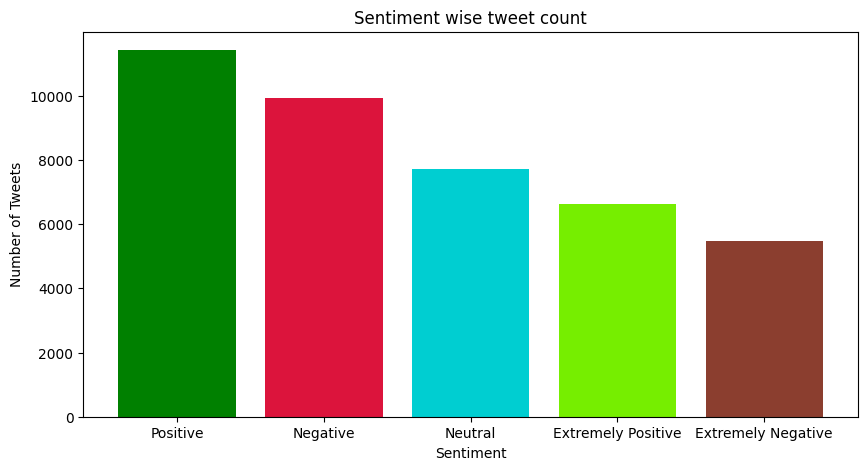

In [ ]:
plt.subplots(figsize=(10,5))
plt.bar(sentiments.index,sentiments.values, color=['green','#DC143C','#00CED1','#76EE00','#8B3E2F'])
plt.title("Sentiment wise tweet count")
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

<ipython-input-24-0e1d46418139>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)
<ipython-input-24-0e1d46418139>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tweet_lengths)


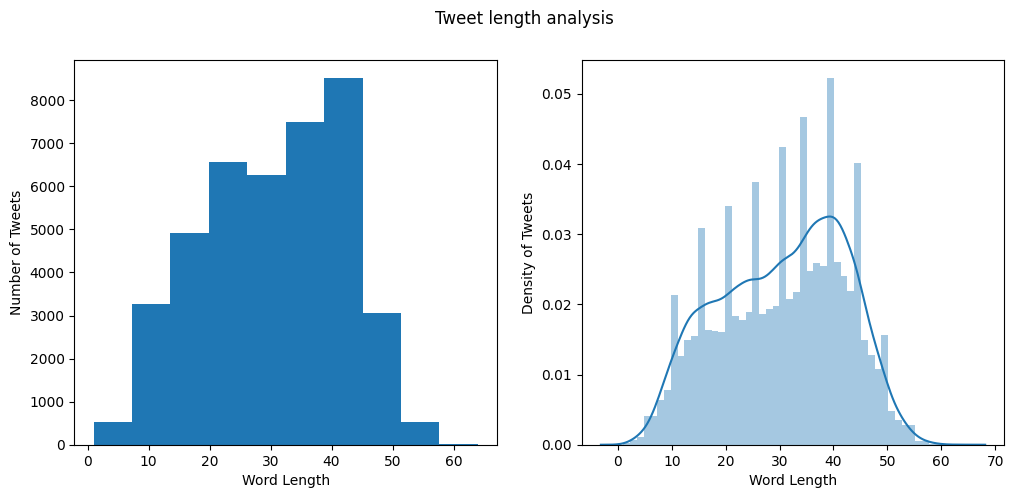

In [ ]:
tweet_lengths = df['OriginalTweet'].apply(lambda x: len(x.split()))

plt.subplots(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(tweet_lengths)
plt.suptitle("Tweet length analysis")
plt.xlabel("Word Length")
plt.ylabel("Number of Tweets")

plt.subplot(1,2,2)
sns.distplot(tweet_lengths)
plt.xlabel("Word Length")
plt.ylabel("Density of Tweets")
plt.show()

In [18]:
# tweet cleaning
# tweets with a low number of tokens should be eliminated

def preprocessing(x):
    # helper functions:
    def remove_hashtags(text): return re.sub(r'#\w*', ' ' , text)
    def remove_mentions(text): return re.sub(r'@\w*', ' ' , text)
    def remove_urls(text): return re.sub(r'https?://\S+', ' ', text)
    def remove_apostrophe(text): return re.sub(r"'s\b", "", text)
    def remove_special_chars(text): return re.sub(r"[^a-zA-Z0-9\s]", ' ', text)
    def remove_numbers(text): return re.sub(r'[\d]', ' ', text)
    def remove_formatting_symbols(text): return re.sub(r"[\r\n]+",'',text)
    def remove_escape_characters(text): return re.sub(r"\\",'',text)
    def remove_extra_spaces(text): return re.sub(r"\s{2,}",' ',text)
    x=x.apply(remove_hashtags)
    x=x.apply(remove_mentions)
    x=x.apply(remove_urls)
    x=x.apply(remove_apostrophe)
    x=x.apply(remove_special_chars)
    x=x.apply(remove_numbers)
    x=x.apply(remove_formatting_symbols)
    x=x.apply(remove_escape_characters)
    x=x.apply(remove_extra_spaces)
    x=x.str.lower()
    return x

In [ ]:
%%time
df['OriginalTweet']=preprocessing(df['OriginalTweet'])
df

CPU times: user 1.36 s, sys: 0 ns, total: 1.36 s
Wall time: 1.39 s


,OriginalTweet,Sentiment
0,and and,Neutral
1,advice talk to your neighbours family to excha...,Positive
2,coronavirus australia woolworths to give elder...,Positive
3,my food stock is not the only one which is emp...,Positive
4,me ready to go at supermarket during the outbr...,Extremely Negative
...,...,...
41152,airline pilots offering to stock supermarket s...,Neutral
41153,response to complaint not provided citing covi...,Extremely Negative
41154,you know it s getting tough when is rationing ...,Positive
41155,is it wrong that the smell of hand sanitizer i...,Neutral


In [ ]:
# checking random tweet:
df.iloc[41153,0]

'response to complaint not provided citing covid related delays yet prompt in rejecting policy before consumer tat is over way to go '

In [ ]:
# function to build sentiment wisewordcloud:
def show_wordcloud(df):
    sentiments=df.Sentiment.value_counts().index.to_list()
    
    stopwords = set(STOPWORDS)
    
    plt.subplots(figsize=(14,14))
    i=1
    for senti in sentiments:
        curr=df['OriginalTweet'].loc[df.Sentiment==senti]
        text=curr.values
        text=' '.join(text)
        
        wordcloud=WordCloud(max_words=100, stopwords=stopwords, background_color='white', max_font_size=50).generate(text)
        
        plt.subplot(3,2,i)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(senti,fontsize=15)
        i+=1

<ipython-input-28-2de648a3933a>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i)


CPU times: user 6.02 s, sys: 88.5 ms, total: 6.11 s
Wall time: 6.18 s


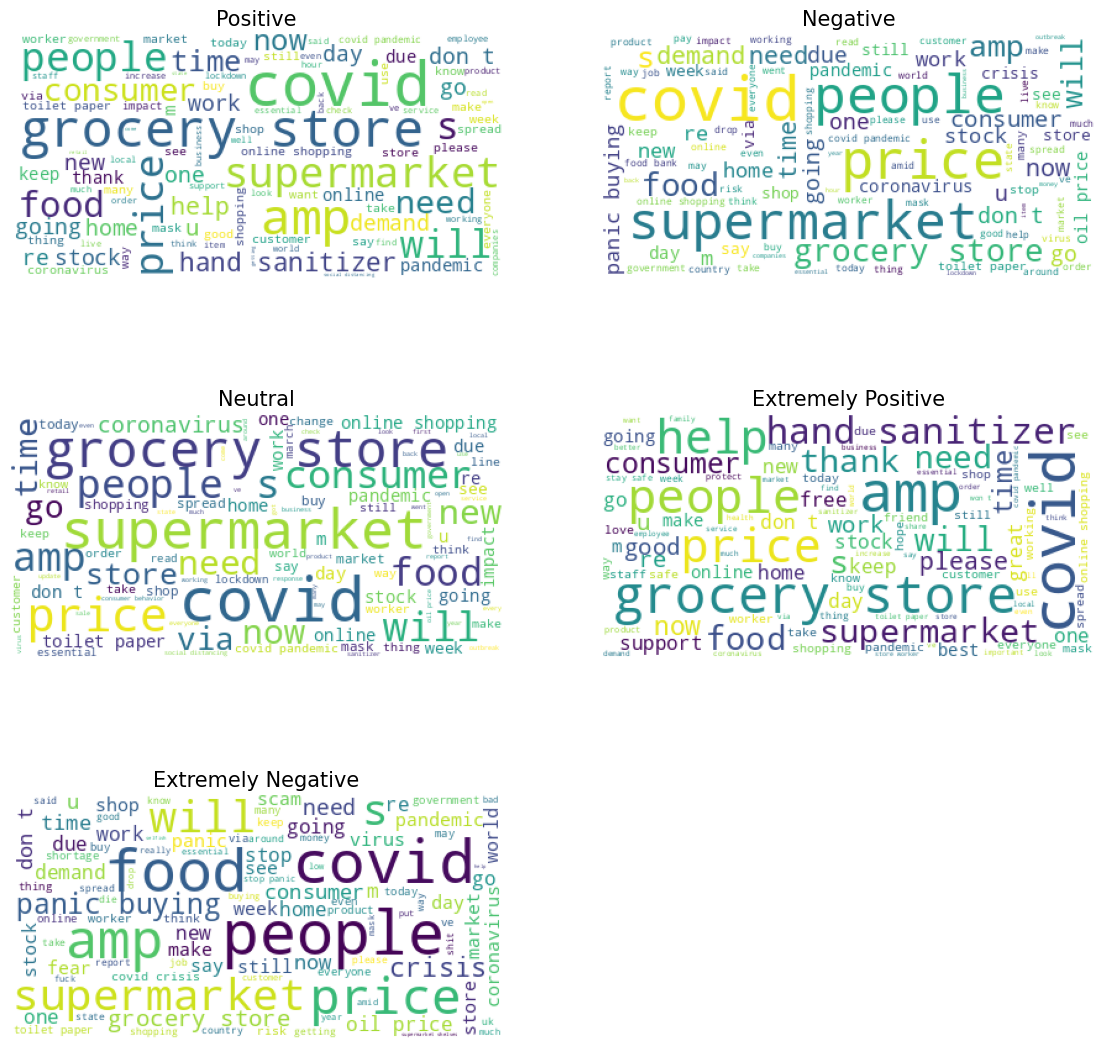

In [ ]:
%%time
# generating wordclouds:
show_wordcloud(df)

In [19]:
# function for label reduction and encoding:
def label_preprocessing(labels):
    lab_dict={
        'Extremely Negative': 0,
        'Negative': 1,
        'Neutral': 2,
        'Positive': 3,
        'Extremely Positive': 4
    }
    labels=labels.map(lab_dict)
    
    return labels

In [20]:
%%time
# label preprocessing:
df['Sentiment']=label_preprocessing(df['Sentiment'])
df

CPU times: user 5.23 ms, sys: 56 µs, total: 5.28 ms
Wall time: 5.63 ms


,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2.0
1,advice Talk to your neighbours family to excha...,3.0
2,Coronavirus Australia: Woolworths to give elde...,3.0
3,My food stock is not the only one which is emp...,3.0
4,"Me, ready to go at supermarket during the #COV...",0.0
...,...,...
28662,Health insurance premiums could rise up to 40 ...,3.0
28663,The says grandparent and family emergency scam...,0.0
28664,@ErickMarrero_ ....and that's just from Covid-...,3.0
28665,If u cant find TP ( #toiletPaper ) at the stor...,2.0


In [ ]:
senti=df['Sentiment'].value_counts()
senti

3    11422
1     9917
2     7713
4     6624
0     5481
Name: Sentiment, dtype: int64

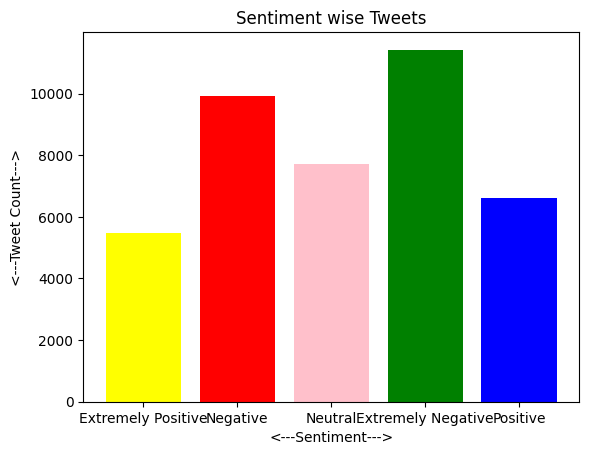

In [ ]:
# this must be plotted correctly, it is all wrong
plt.bar(senti.index, senti.values, color=['green','red','pink', 'blue', 'yellow'])
plt.xticks(senti.index, ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'])
plt.title('Sentiment wise Tweets')
plt.xlabel('<---Sentiment--->')
plt.ylabel('<---Tweet Count--->')
plt.show()

In [101]:
df_to_use = df.iloc[27480:28480]
df_to_use

,OriginalTweet,Sentiment
27480,What Italy s market can tell us about the futu...,2.0
27481,Check out the recent @FTC blog post. Here are ...,3.0
27482,A virtual food drive Thank you London Food ban...,3.0
27483,ICYMI Petrol prices are dropping in the wake o...,2.0
27484,"This is my a supermarket clerk, a lot of you a...",0.0
...,...,...
28475,Cant believe this has to be said but I keep he...,4.0
28476,We're spreading the light to vanquish the dark...,1.0
28477,Inter city public transportation will never be...,1.0
28478,End of mass mobility as we know in India.\r\r\...,1.0


In [102]:
df_to_use_tweet_list = df_to_use["OriginalTweet"]
tweet_list = df_to_use_tweet_list.to_list()


df_to_use_sentiments = df_to_use["Sentiment"]
sentiment_list = df_to_use_sentiments.to_list()

for index in range(0, len(tweet_list)):
  if tweet_list[index] == "":
    del tweet_list[index]
    del sentiment_list[index]

train_idx = int(len(tweet_list)*80 // 100) 

tweet_list_train = tweet_list[:train_idx]
tweet_list_val = tweet_list[train_idx:]
sentiment_list_train = sentiment_list[:train_idx]
sentiment_list_val = sentiment_list[train_idx:]

print(tweet_list_train[0])
print(sentiment_list_train[0])

What Italy s market can tell us about the future of UK house prices
2.0


In [103]:
print(np.unique(sentiment_list_train, return_counts = True))
print(np.unique(sentiment_list_val, return_counts = True))

(array([0., 1., 2., 3., 4.]), array([108, 180, 142, 239, 131]))
(array([0., 1., 2., 3., 4.]), array([28, 54, 35, 51, 32]))


# What to feed to the networks?

It is important to note that computing the above mentioned graph structure
for each entry of the dataset is costly in terms of time, given the large amount
of entries, thus a pre-computed version of the dataset can be uploaded to Google drive.
By calling the constructor of the class `Dataset_from_sentences`, the dataset in the corresponding drive folder will be loaded in Colab and also in memory, ready for training.

In [24]:
from google.colab import auth
auth.authenticate_user()

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(os.listdir("/content/drive/MyDrive/GraphDataset/train/"))

[]


In [104]:
# class containing the graph data that must be fed into the GCNs or GAT networks
class Dataset_from_sentences(Dataset):
    def __init__(self, name, path_were_save, drive_dir, sentences_list, y_values, transform=None):
      self.name = name
      self.drive_dir = drive_dir
      self.raw_url = self.drive_dir + self.name + ".pt"
      self.data_list = []
      self.sentences_list = sentences_list
      self.y_values = y_values
      super().__init__(path_were_save, transform)
      if os.path.exists(self.raw_paths[0]):
        self.data_list = torch.load(self.raw_paths[0])
      else:
        print("something strange happened")
        

    @property
    def processed_file_names(self):
      return self.raw_paths[0]

    @property 
    def raw_paths(self):
      to_return = self.root + "/" + self.name + ".pt"
      return [to_return]
      

    def download(self):
      if os.path.exists(self.raw_url):
        shutil.copy(self.raw_url, self.raw_paths[0])
      else:
        pass


    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

    def __build_graph_Data__(self, sentence, y_val):  
      tok_dep_dict = get_tokens_and_dependencies(sentence)
      intra_sentence_data_list = []
      if len(tok_dep_dict.keys()) > 0:
        for i in range(0, len(tok_dep_dict.keys()) // 2):
          bert_input = get_bert_input_from_tokens(tok_dep_dict[f"{i} tokens"])
          bert_output = bert_model(**bert_input)
          bert_output_states = bert_output.last_hidden_state[0, :, :].clone().detach().requires_grad_()
          bert_pooler_output = bert_output.pooler_output[0, :].clone().detach().requires_grad_()
          
          node_features = torch.vstack((bert_pooler_output, bert_output_states)) 
          edge_idxs = torch.tensor(tok_dep_dict[f"{i} dependency"], dtype = torch.int64)
          data = Data(x = node_features, edge_index = edge_idxs) #, y = y_val)
          intra_sentence_data_list.append(data)
        # the instructions below are equivalent to Batch.from_data_list
        # and are needed to collate the Data objects related to a single sample
        # correctly
        dl = DataLoader(intra_sentence_data_list, len(intra_sentence_data_list), shuffle = False)
        for batch in dl:
          batch.y = y_val
          return batch
      else:
        return None
    

    def to(self, device):
      self.data_list.to(device)
      return self


    def process(self):
      num_invalid = 0
      for idx, elem in tqdm(enumerate(self.sentences_list)):
        to_save = self.__build_graph_Data__(elem, self.y_values[idx])
        if to_save is not None:
          self.data_list.append(to_save)
        else:
          num_invalid += 1
      torch.save(Batch.from_data_list(self.data_list), self.raw_paths[0])
      torch.save(Batch.from_data_list(self.data_list), self.raw_url)

In [105]:
# function needed to clear a directory, it is necessary to call this function
# if some modifications to the dataset must be performed, like
# generating a smaller dataset containing a subset of the examples
def delete_processed_files(directory):
  if os.path.exists(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
              for elem in os.listdir(file_path):
                os.unlink(osp.join(file_path, elem))
              os.rmdir(file_path)
        except Exception as e:
            print('Cannot eliminate {}: {}'.format(file_path, e))
    print(f"Now {directory} is empty")
  else:
      print("The directory does not exist")

In [106]:
delete_processed_files("/content/processed_train/")
delete_processed_files("/content/drive/MyDrive/GraphDataset/train")

delete_processed_files("/content/processed_val/")
delete_processed_files("/content/drive/MyDrive/GraphDataset/val")

Now /content/processed_train/ is empty
Now /content/drive/MyDrive/GraphDataset/train is empty
Now /content/processed_val/ is empty
Now /content/drive/MyDrive/GraphDataset/val is empty


In [107]:
# construction of the training and validation datasets
cv19_graph_data_train = Dataset_from_sentences("train", "/content/processed_train/", "/content/drive/MyDrive/GraphDataset/train/", tweet_list_train, sentiment_list_train)
cv19_graph_data_val = Dataset_from_sentences("validation", "/content/processed_val/", "/content/drive/MyDrive/GraphDataset/val/", tweet_list_val, sentiment_list_val)

Processing...
800it [05:08,  2.59it/s]
Done!
Processing...
200it [01:16,  2.62it/s]
Done!


In [38]:
print(cv19_graph_data_train.data_list)

DataBatch(x=[2869, 768], edge_index=[2, 2869], y=[201], batch=[2869])


In [ ]:
delete_processed_files("/content/drive/MyDrive/GraphDataset/train/")

Now /content/drive/MyDrive/GraphDataset/train/ is empty


In [ ]:
print(len(cv19_graph_data_train))
print(cv19_graph_data_train.num_node_features)

16
768


# Minibatching

The following block shows an example of how minibatching is handled by `torch_geometric`.
Essentially the graphs adjecency matrices are collated together in a single object representing a block diagonal matrix, while features are placed in a tensor of shape (num_nodes, num_features) where num_nodes is the total number of nodes of the graphs in the minibatch. <br>
The ground truth labels are stacked graph-wise in a tensor.

In [69]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


print("Data built from list of sentences:\n " + str(cv19_graph_data_train))

data = cv19_graph_data_train.to(device)
print(data[0].x.get_device())
print(data.data_list[0].edge_index.get_device()) 
print(data.data_list[0].y.get_device())
print("________________________________")

loader =  DataLoader(cv19_graph_data_train.data_list, batch_size=10, shuffle=True)

for batch in loader:
  # each minibatch is again a Data object 
  print("The current batch is the following object:\n " + str(batch))
  print("The number of graphs in the current batch is:\n " + str(batch.num_graphs))
  print("The number of nodes for this batch is: \n" + str(batch.x.shape))
  #print(batch.x.device)
  #print("The edge indexes for the current batch are:\n " + str(batch.edge_index.shape))
  #print(batch.edge_index.device)
  #print(batch.edge_index)
  #print(batch.edge_index.shape[1] in batch.edge_index)
  print("The ground truth vector is:\n " + str(batch.y))
  print("The batch vector is: " + str(batch.batch))
  #print(batch.y.device)

  for i in range(0, batch.num_graphs):
    print("__________AAA__________")
    print(f"elem {i}:")
    print("the graph is: " + str(batch[i]))
    print("nodes shape:\n " + str(batch[i].x.shape))
    print("edges idxs for the current sample:\n " + str(batch[i].edge_index))
    print("ground truth shape:\n " + str(batch[i].y))

  # batch is a column vector that maps each node to its respective 
  # graph in the batch, it can be accessed with ".batch" and can 
  # be used to aggregate features of each nodes for each individual graph
  x = scatter(batch.x, batch.batch, dim = 0, reduce = "mean")
 
  print(batch.x.shape) 
  
  print(x.shape)
  break

<IPython.core.display.Javascript object>

Data built from list of sentences:
 Dataset_from_sentences(80)
0
0
0
________________________________
The current batch is the following object:
 DataBatch(x=[342, 768], edge_index=[2, 342], batch=[342], y=[10], ptr=[11])
The number of graphs in the current batch is:
 10
The number of nodes for this batch is: 
torch.Size([342, 768])
The ground truth vector is:
 tensor([2., 2., 2., 3., 1., 4., 1., 2., 1., 1.], device='cuda:0')
The batch vector is: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

# Visualization of an entry of the dataset

COVID-19 Impact on Consumer Goods Sector #Covid_19 #COVID2019 #usacovid19 @ https://t.co/iiNyKuLJtb


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


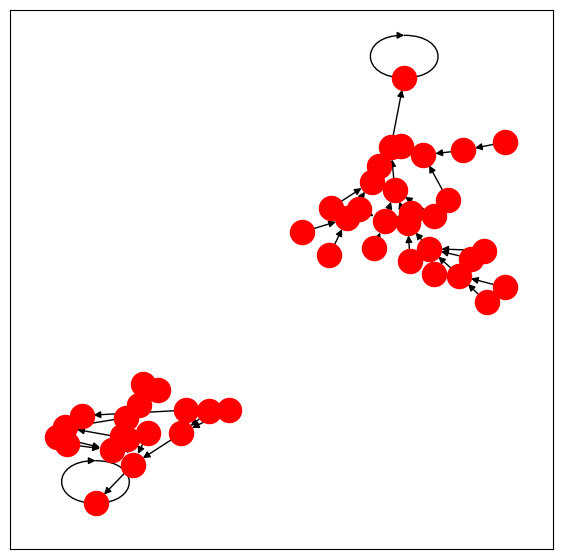

In [76]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

print(tweet_list_train[1])
G = to_networkx(cv19_graph_data_train[8], to_undirected=False)
visualize_graph(G, color="red")

In [40]:
def visualize_embedding(h, labels, epoch=None, loss=None):
  """
  Function needed to plot the embeddings obtained as output of the GNNs
  before computing the classification scores, this is needed to 
  understand if graph-embeddings are separable at inference time.

  Params:
    h: the tensor containing the graph-embeddings of shape [num_graphs, 2]
    labels: the labels corresponding to the graphs in h
    epoch: the epoch were the embedding has been computed
    loss: the obtained (validation) loss for that epoch 
  """
  plt.figure(figsize=(7,7))
  plt.xticks([])
  plt.yticks([])
  h = h.detach().cpu().numpy()
  lab_dict = {0:"red", 1:"green", 2:"blue", 3:"yellow", 4:"black"}
  color = [lab_dict[elem] for elem in labels.tolist()]
  plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
  if epoch is not None and loss is not None:
      plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
  plt.show()

In [41]:
def convert_to_DiGraph(data):
  """
  Function that takes in input a torch_geometric data object and 
  converts it to a nx.
  """
  nodes = range(0, data.num_nodes)
  G = nx.DiGraph()
  edge_list = [(elem.item(), data.edge_index[1][idx].item()) for idx, elem in 
               enumerate(data.edge_index[0])]
  G.add_edges_from(edge_list)
  return G

data_ex = cv19_graph_data_train[0] 
print(data_ex.num_nodes)
di_graph = to_networkx(data_ex)
print(di_graph)
print(nx.shortest_path_length(di_graph, source = 1, target = 0))

35
DiGraph with 35 nodes and 35 edges
2


# Statistics about the graphs

Here we compute and plot:
- mean number of nodes
- average node degree
- mean average path length (since we have a huge number of graphs it is suggested to run this costly operation for a subset of the dataset)
- degree distribution 

The mean number of nodes is: 35.86
Average node degree: 80.00
Mean average path length among graphs: inf
Degree distribution: 


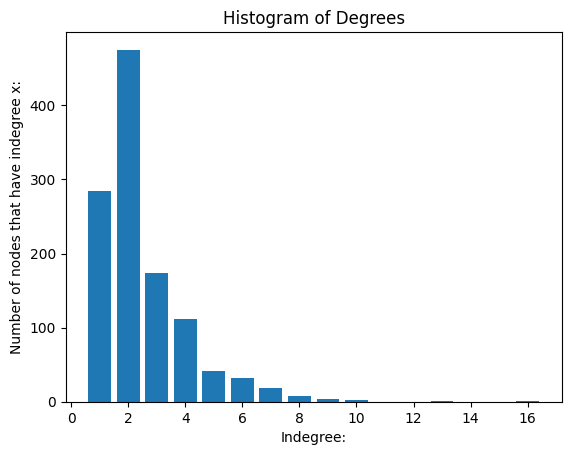

In [70]:
def compute_node_degree_distribution(dataset, indegree_flag = True):
  dict_counts = {}
  for elem in dataset:
    if indegree_flag:
      current_graph_degrees = np.unique(elem.edge_index[1].cpu(), return_counts = True)[1]
      current_graph_unique_degrees, current_graph_degree_counts = np.unique(current_graph_degrees, return_counts = True)
      for idx, unique_deg in enumerate(current_graph_unique_degrees):
        if unique_deg not in dict_counts.keys():
          dict_counts.update({unique_deg : current_graph_degree_counts[idx]})
        else: 
          dict_counts[unique_deg] += current_graph_degree_counts[idx]
  return dict_counts

def plot_node_degree_distribution(dataset):
  dict_to_plot = compute_node_degree_distribution(dataset)
  plt.bar(dict_to_plot.keys(), dict_to_plot.values())
  plt.title('Histogram of Degrees')
  plt.xlabel('Indegree:')
  plt.ylabel('Number of nodes that have indegree x:')

def avg_path_length(data):
    # Convert the graph to an undirected graph
    edge_index = to_undirected(data.edge_index)

    # Compute the degree of each node in the graph
    deg = degree(edge_index[0], num_nodes=data.num_nodes, dtype=torch.long)

    # Compute the shortest path between each pair of nodes in the graph
    shortest_paths = torch.zeros(data.num_nodes, data.num_nodes)
    for i in range(data.num_nodes):
        for j in range(i+1, data.num_nodes):
            try:
                #print(f"indexes (i, j): {i} {j}")
                path = torch.tensor(nx.shortest_path_length(nx.Graph(convert_to_DiGraph(data)), source=i, target=j))
                #print(f"path: {path}")
                shortest_paths[i][j] = path
                shortest_paths[j][i] = path
            except nx.NetworkXNoPath:
                shortest_paths[i][j] = float('inf')
                shortest_paths[j][i] = float('inf')
    # Compute the average path length of the graph
    num_paths = data.num_nodes * (data.num_nodes - 1) / 2
    avg_path_length = torch.sum(shortest_paths) / num_paths
    
    return avg_path_length

def mean_average_path_length(dataset):
  avg_path_lengths = np.array([avg_path_length(elem) for elem in dataset])
  return np.mean(avg_path_lengths)

def compute_avg_node_degree(dataset):
  avg_node_deg = 0
  i = 0
  for elem in dataset:
    avg_node_deg += elem.num_edges / elem.num_nodes
    i += 1
  return avg_node_deg

def compute_mean_number_of_nodes(dataset):
  return np.mean([elem.num_nodes for elem in dataset])


print(f"The mean number of nodes is: {compute_mean_number_of_nodes(cv19_graph_data_train):.2f}")
print(f'Average node degree: {compute_avg_node_degree(cv19_graph_data_train):.2f}')
print(f"Mean average path length among graphs: {mean_average_path_length(cv19_graph_data_train):.2f}")
print("Degree distribution: ")
plot_node_degree_distribution(cv19_graph_data_train)

In [108]:
from torch.optim.lr_scheduler import StepLR
batch_size = 32


# GCN definition
class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h_1, dim_h_2, dim_out):
    super().__init__()
    # dim_in is the number of node features, dim_h is the dimension
    # of the hidden layer, dim_out is the dimension of the output
    # feature vector
    self.gcn1 = GCNConv(dim_in, dim_h_1)
    self.gcn2 = GCNConv(dim_h_1, dim_h_2)
    self.gcn3 = GCNConv(dim_h_2, 2)
    
    self.classifier = Linear(2, dim_out)

    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=1e-3)
                                      #weight_decay=5e-5)

  def forward(self, x, edge_index, batch):
    # the parameters of the forward correspond to data.x and data.edge_index
    # where data is a Data object like those described above;
    h = self.gcn1(x, edge_index)
    h = h.tanh()
    h = self.gcn2(h, edge_index)
    h = h.tanh()
    h = self.gcn3(h, edge_index)
    h = h.tanh()
    h = global_mean_pool(h, batch)
    embed_to_plot = h
    h = self.classifier(h)
    return embed_to_plot, h
    

# actual GAT class
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h_1, dim_h_2, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h_1, heads=heads)
    self.gat2 = GATv2Conv(dim_h_1*heads, dim_h_2, heads=heads)
    self.gat3 = GATv2Conv(dim_h_2*heads, 2, heads=1)
    self.classifier = Linear(2, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=1e-3)
                                      # weight_decay=5e-4)

  def forward(self, x, edge_index, batch):
    h = self.gat1(x, edge_index)
    h = h.tanh()
    h = self.gat2(h, edge_index)
    h = h.tanh()
    h = self.gat3(h, edge_index)
    h = h.tanh()
    h = global_mean_pool(h, batch)
    h = self.classifier(h)
    return h

class EarlyStopper:
  def __init__(self, patience=1, min_delta=0):
      self.patience = patience
      self.min_delta = min_delta
      self.counter = 0
      self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
      if validation_loss < self.min_validation_loss:
          self.min_validation_loss = validation_loss
          self.counter = 0
      elif validation_loss > (self.min_validation_loss + self.min_delta):
          self.counter += 1
          if self.counter >= self.patience:
              return True
      return False

def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation losses over the course of training.
    Args:
        train_losses: A list of training losses.
        val_losses: A list of validation losses.
    """
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model):
    """Train a GNN model and return the trained model."""
    epochs = 100
    criterion = torch.nn.CrossEntropyLoss() # thank god I don't have to onehot encode the labels
    optimizer = model.optimizer
    scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
    loader_train =  DataLoader(cv19_graph_data_train.data_list, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(cv19_graph_data_val.data_list, batch_size=batch_size, shuffle=True)
    model.train()
    early_stopper = EarlyStopper(patience=10, min_delta=0.4)

    train_losses = []
    val_losses = []

    for epoch in range(epochs+1):
      for batch in loader_train:
        # Training
        optimizer.zero_grad()
        # for some reason, the edge indexes that were placed on device by 
        # the "to" method find themselves on cpu, so we force them to be on device

        _, out = model(batch.x, batch.edge_index, batch.batch)
        loss_train = criterion(out, batch.y.long())
        acc_train = accuracy(out.argmax(dim=1), batch.y)
        loss_train.backward()
        optimizer.step()  
      train_losses.append(loss_train.item()) 
      scheduler.step()
      for batch in loader_val:
        embed, out = model(batch.x, batch.edge_index, batch.batch)
        loss_val = criterion(out, batch.y.long())
        acc_val = accuracy(out.argmax(dim=1), batch.y)
        #visualize_embedding(embed, batch.y, epoch, loss_val)
      val_losses.append(loss_val.item())
      if(epoch % 10 == 0):
        print(f'Epoch {epoch:>3} | Train Loss: {loss_train:.3f} | Train Acc: '
              f'{acc_train*100:>6.2f}%')
        print(f'Epoch {epoch:>3} | Val Loss: {loss_val:.3f} | Val Acc: '
              f'{acc_val*100:>6.2f}%')
      if early_stopper.early_stop(loss_val):             
        break
    plot_losses(train_losses, val_losses)
    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [109]:
model_gcn = GCN(cv19_graph_data_train.num_node_features, 384, 192, cv19_graph_data_train.num_classes).to(device)
print(model_gcn)

GCN(
  (gcn1): GCNConv(768, 384)
  (gcn2): GCNConv(384, 192)
  (gcn3): GCNConv(192, 2)
  (classifier): Linear(in_features=2, out_features=5, bias=True)
)


In [110]:
data_train = cv19_graph_data_train.to(device)
data_val = cv19_graph_data_val.to(device)

Epoch   0 | Train Loss: 1.604 | Train Acc:  21.88%
Epoch   0 | Val Loss: 1.631 | Val Acc:  25.00%
Epoch  10 | Train Loss: 1.522 | Train Acc:  34.38%
Epoch  10 | Val Loss: 1.569 | Val Acc:  25.00%
Epoch  20 | Train Loss: 1.566 | Train Acc:  25.00%
Epoch  20 | Val Loss: 1.480 | Val Acc:  37.50%
Epoch  30 | Train Loss: 1.545 | Train Acc:  34.38%
Epoch  30 | Val Loss: 1.688 | Val Acc:  25.00%
Epoch  40 | Train Loss: 1.584 | Train Acc:  34.38%
Epoch  40 | Val Loss: 1.682 | Val Acc:  25.00%
Epoch  50 | Train Loss: 1.519 | Train Acc:  34.38%
Epoch  50 | Val Loss: 1.584 | Val Acc:  25.00%
Epoch  60 | Train Loss: 1.480 | Train Acc:  25.00%
Epoch  60 | Val Loss: 1.593 | Val Acc:  12.50%
Epoch  70 | Train Loss: 1.370 | Train Acc:  37.50%
Epoch  70 | Val Loss: 1.461 | Val Acc:  37.50%
Epoch  80 | Train Loss: 1.118 | Train Acc:  53.12%
Epoch  80 | Val Loss: 1.690 | Val Acc:  12.50%


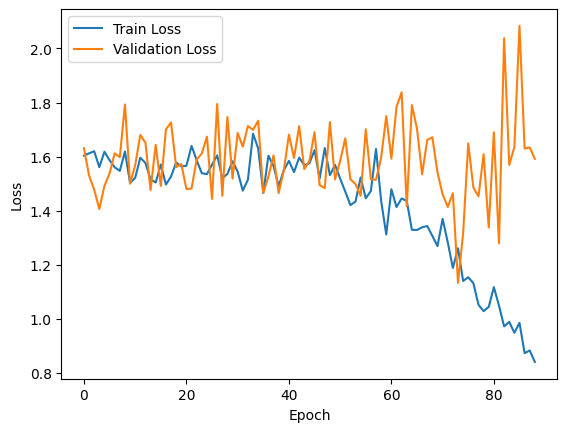

In [111]:
trained_gcn = train(model_gcn)

In [ ]:
model_gat = GAT(cv19_graph_data_train.num_node_features, 5, 5, cv19_graph_data_train.num_classes).to(device)
print(model_gat)

GAT(
  (gat1): GATv2Conv(768, 5, heads=8)
  (gat2): GATv2Conv(40, 5, heads=8)
  (gat3): GATv2Conv(40, 2, heads=1)
  (classifier): Linear(in_features=2, out_features=5, bias=True)
)


In [ ]:
trained_m = train(model_gat)

Epoch   0 | Train Loss: 0.932 | Train Acc:  81.25%
Epoch   0 | Val Loss: 1.650 | Val Acc:   0.00%
Epoch  10 | Train Loss: 0.873 | Train Acc:  87.50%
Epoch  10 | Val Loss: 1.553 | Val Acc:  33.33%
Epoch  20 | Train Loss: 0.853 | Train Acc:  87.50%
Epoch  20 | Val Loss: 1.509 | Val Acc:  33.33%
Epoch  30 | Train Loss: 0.834 | Train Acc:  87.50%
Epoch  30 | Val Loss: 1.541 | Val Acc:  33.33%
Epoch  40 | Train Loss: 0.816 | Train Acc:  87.50%
Epoch  40 | Val Loss: 1.508 | Val Acc:  33.33%
Epoch  50 | Train Loss: 0.799 | Train Acc:  87.50%
Epoch  50 | Val Loss: 1.490 | Val Acc:  33.33%
Epoch  60 | Train Loss: 0.783 | Train Acc:  87.50%
Epoch  60 | Val Loss: 1.491 | Val Acc:  33.33%
Epoch  70 | Train Loss: 0.767 | Train Acc:  87.50%
Epoch  70 | Val Loss: 1.487 | Val Acc:  66.67%
Epoch  80 | Train Loss: 0.753 | Train Acc:  87.50%
Epoch  80 | Val Loss: 1.482 | Val Acc:  66.67%
Epoch  90 | Train Loss: 0.739 | Train Acc:  87.50%
Epoch  90 | Val Loss: 1.481 | Val Acc:  66.67%
Epoch 100 | Train Lo

In [ ]:
# the worst loss that we can have is:
worst_loss = - np.log(1/cv19_graph_data_train.num_classes)
print(worst_loss)

1.6094379124341005
